In [134]:
import pandas as pd
import numpy as np
import pickle
from pandas import ExcelWriter
import ffn
%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

#pull in data from AlphaVantage
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='NXY0VT9AHBRYGKKC',output_format='pandas')

In [113]:
def historical_data(ticker, outsize = "full"):
    #outsize can be compact and full. 
    #compact returns only the latest 100 data points; full 
    #returns the full-length time series of up to 20 years of historical data. The "compact" option is 
    #recommended if you would like to reduce the data size of each API call
    alphavantage_link = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={0}&apikey=NXY0VT9AHBRYGKKC&datatype=csv&outputsize={1}'.format(ticker, outsize)
    df = pd.read_csv(alphavantage_link)
    return df

In [114]:
VAA = ['AGG', 'EFA', 'EEM','LQD','IEF','SHY']
Maindf = historical_data("SPY")
Maindf.index = pd.to_datetime(Maindf.timestamp) #set the index as the timestamp
#Maindf.index = pd.to_datetime(Maindf.index) #make the index datetime
Maindf = Maindf[['timestamp','close']]
Maindf.columns = ["timestamp","SPY"]

In [115]:
for ticker in VAA:
    temp_df = historical_data(ticker)
    temp_df.index = pd.to_datetime(temp_df.timestamp) #set the index as the timestamp
    temp_df = temp_df[['close']]
    temp_df.columns = [ticker]
    Maindf = Maindf.join(temp_df, how = "left")

Maindf.dropna(inplace = True)
Maindf = Maindf.sort_index()

In [116]:
Maindf = Maindf.sort_index()

In [119]:
Maindf['Year'] = Maindf.index.year
Maindf['Month'] = Maindf.index.month
Maindf['Day'] = Maindf.index.day
Maindf['Month Change'] = Maindf['Month'] - Maindf['Month'].shift(-1) #shift -1 moves row up 

In [120]:
Maindf.head(10)

,timestamp,SPY,AGG,EFA,EEM,LQD,IEF,SHY,Year,Month,Day,Month Change
timestamp,,,,,,,,,,,,
2003-09-26,2003-09-26,99.95,102.45,117.00,135.40,111.85,86.13,82.60,2003,9,26,0.0
2003-09-29,2003-09-29,100.93,102.17,118.50,136.36,111.55,85.76,82.56,2003,9,29,0.0
2003-09-30,2003-09-30,99.95,102.70,117.00,135.93,112.29,86.59,82.73,2003,9,30,-1.0
2003-10-01,2003-10-01,102.08,102.65,120.84,139.50,111.88,86.24,82.65,2003,10,1,0.0
2003-10-02,2003-10-02,102.45,102.49,120.65,141.50,111.45,85.93,82.65,2003,10,2,0.0
2003-10-03,2003-10-03,103.39,101.75,122.41,142.90,109.90,84.74,82.44,2003,10,3,0.0
2003-10-06,2003-10-06,103.86,101.90,123.69,143.45,110.01,84.99,82.50,2003,10,6,0.0
2003-10-07,2003-10-07,104.26,101.55,123.50,143.30,109.64,84.50,82.42,2003,10,7,0.0
2003-10-08,2003-10-08,104.00,101.80,122.99,144.37,110.04,84.65,82.42,2003,10,8,0.0


In [121]:
Maindf_EOM = Maindf[Maindf['Month Change'] != 0]
Maindf_EOM = Maindf_EOM[['SPY','AGG','EFA','EEM','LQD','IEF','SHY']]

In [122]:
Maindf_EOM_VAA = Maindf_EOM.pct_change(12) + 2 * Maindf_EOM.pct_change(6) + 4 * Maindf_EOM.pct_change(3) + 12 * Maindf_EOM.pct_change(1)

In [123]:
Maindf_EOM_VAA.tail(3)

,SPY,AGG,EFA,EEM,LQD,IEF,SHY
timestamp,,,,,,,
2018-04-30,-0.016480,-0.310711,0.155278,-0.461291,-0.512819,-0.365218,-0.098303
2018-05-31,0.448191,-0.037642,-0.246528,-0.417471,-0.151303,0.003708,0.000828
2018-06-18,0.656300,-0.219652,0.012865,-0.595846,-0.373878,-0.245064,-0.074249


In [124]:
Maindf_EOM_VAA['Indicator'] = np.where(Maindf_EOM_VAA[['SPY','AGG','EFA','EEM']].min(axis = 1) > 0, Maindf_EOM_VAA[['SPY','AGG','EFA','EEM']].idxmax(axis = 1), Maindf_EOM_VAA[['LQD','IEF','SHY']].idxmax(axis = 1))

In [125]:
Maindf_EOM_VAA.tail(10)

,SPY,AGG,EFA,EEM,LQD,IEF,SHY,Indicator
timestamp,,,,,,,,
2017-09-29,0.630242,-0.095409,0.841509,0.796887,0.026885,-0.224357,-0.043081,LQD
2017-10-31,0.821054,-0.032121,0.749895,1.176776,0.029542,-0.110077,-0.049771,LQD
2017-11-30,1.047712,-0.096997,0.631815,0.603100,-0.037711,-0.171872,-0.086394,LQD
2017-12-29,0.733749,0.026478,0.515784,1.094493,0.154199,-0.062788,-0.077804,EEM
2018-01-31,1.584975,-0.215090,1.289112,2.103068,-0.176415,-0.448897,-0.101025,SHY
2018-02-28,0.007909,-0.317373,-0.305730,-0.134892,-0.506558,-0.409951,-0.095022,SHY
2018-03-29,-0.219928,-0.076286,0.017090,0.544013,-0.172176,-0.055630,-0.029012,SHY
2018-04-30,-0.016480,-0.310711,0.155278,-0.461291,-0.512819,-0.365218,-0.098303,SHY
2018-05-31,0.448191,-0.037642,-0.246528,-0.417471,-0.151303,0.003708,0.000828,IEF


In [126]:
Maindf_EOM_VAA.columns = ['SPY_MOMP','AGG_MOMP','EFA_MOMP','EEM_MOMP','LQD_MOMP','IEF_MOMP','SHY_MOMP','indicator']

In [127]:
Maindf_Merged = Maindf_EOM.join(Maindf_EOM_VAA, how = "left").dropna()

In [159]:
Maindf_Daily = Maindf[['SPY','AGG','EFA','EEM','LQD','IEF','SHY']]
Maindf_Daily_MOMP = Maindf_Daily.pct_change(252) + 2 * Maindf_Daily.pct_change(132) + 4 * Maindf_Daily.pct_change(66) + 12 * Maindf_Daily.pct_change(22)
Maindf_Daily_MOMP['Indicator'] = np.where(Maindf_Daily_MOMP[['SPY','AGG','EFA','EEM']].min(axis = 1) > 0, Maindf_Daily_MOMP[['SPY','AGG','EFA','EEM']].idxmax(axis = 1), Maindf_Daily_MOMP[['LQD','IEF','SHY']].idxmax(axis = 1))



In [160]:
save_xls([Maindf_EOM,Maindf_EOM_VAA,Maindf,Maindf_Merged,Maindf_Daily_MOMP],"H:\\vaa.xlsx",["PRICES END OF MONTH","MOMP","RAW PRICES","MERGED_DF","Maindf_Daily_MOMP"])

In [129]:
with open('filename.pickle', 'wb') as handle:
    pickle.dump(Maindf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [130]:
with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [137]:
test = Maindf[['SPY','AGG','EFA','EEM']]

In [138]:
perf = test.calc_stats()

C:\Users\scheng\AppData\Local\Continuum\anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


In [139]:
perf.display()

Stat                 SPY         AGG         EFA         EEM
-------------------  ----------  ----------  ----------  ----------
Start                2003-09-26  2003-09-26  2003-09-26  2003-09-26
End                  2018-06-18  2018-06-18  2018-06-18  2018-06-18
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         176.52%     3.31%       -40.71%     -67.02%
Daily Sharpe         0.47        0.07        0.06        0.08
Daily Sortino        0.73        0.10        0.08        0.10
CAGR                 7.15%       0.22%       -3.49%      -7.25%
Max Drawdown         -56.47%     -15.38%     -80.87%     -91.77%
Calmar Ratio         0.13        0.01        -0.04       -0.08

MTD                  2.01%       -0.58%      -0.05%      -2.25%
3m                   0.79%       -0.81%      -1.57%      -9.25%
6m                   3.05%       -3.19%      -2.03%      -4.35%
YTD                  3.57%       -3.19%      -1.34%      -5.22%
1Y                   13.90%      

In [140]:
perf.stats

,AGG,EEM,EFA,SPY
start,2003-09-26 00:00:00,2003-09-26 00:00:00,2003-09-26 00:00:00,2003-09-26 00:00:00
end,2018-06-18 00:00:00,2018-06-18 00:00:00,2018-06-18 00:00:00,2018-06-18 00:00:00
rf,0,0,0,0
total_return,0.0330991,-0.670162,-0.407137,1.76517
cagr,0.00221358,-0.0725486,-0.0348764,0.071505
max_drawdown,-0.153824,-0.917692,-0.808748,-0.564737
calmar,0.0143903,-0.0790555,-0.0431239,0.126617
mtd,-0.00581439,-0.0225432,-0.000504323,0.0200731
three_month,-0.00805061,-0.0924609,-0.0156804,0.0079453
six_month,-0.0319126,-0.0434783,-0.0202684,0.0304944


In [143]:
perf.stats.loc['cagr']

AGG    0.00221358
EEM    -0.0725486
EFA    -0.0348764
SPY      0.071505
Name: cagr, dtype: object

In [144]:
returns = test.to_log_returns().dropna()
 
print(returns.head())

                 SPY       AGG       EFA       EEM
timestamp                                         
2003-09-29  0.009757 -0.002737  0.012739  0.007065
2003-09-30 -0.009757  0.005174 -0.012739 -0.003158
2003-10-01  0.021087 -0.000487  0.032293  0.025925
2003-10-02  0.003618 -0.001560 -0.001574  0.014235
2003-10-03  0.009133 -0.007246  0.014482  0.009845


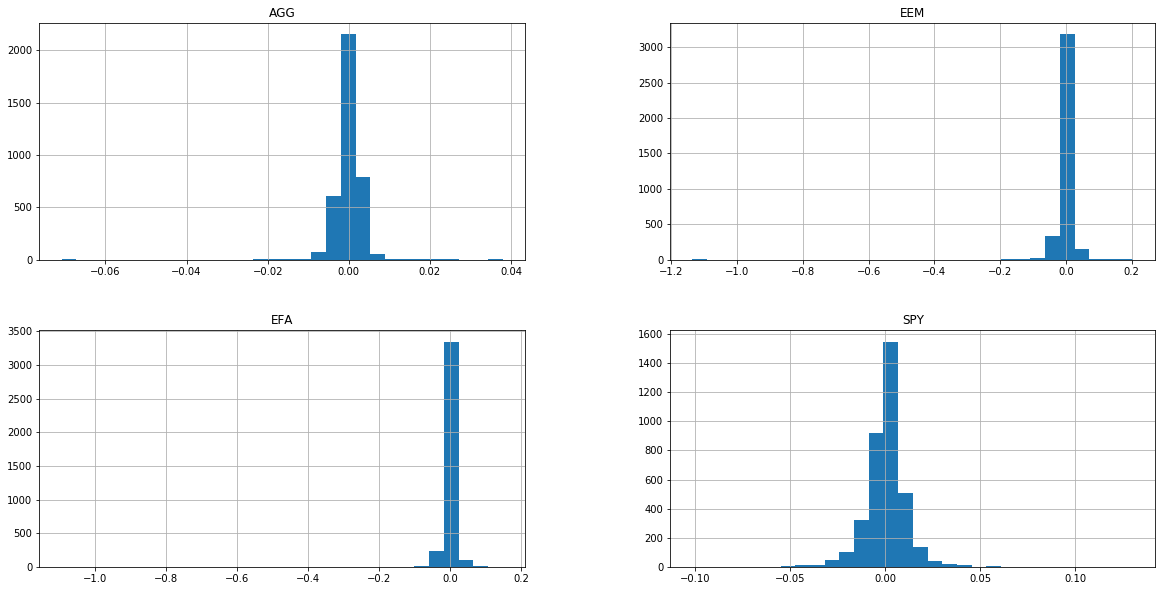

In [145]:
ax = returns.hist(figsize=(20, 10),bins=30)

In [146]:
returns.corr().as_format('.2f')

,SPY,AGG,EFA,EEM
SPY,1.00,-0.12,0.54,0.52
AGG,-0.12,1.00,-0.04,-0.08
EFA,0.54,-0.04,1.00,0.77
EEM,0.52,-0.08,0.77,1.00


<module 'matplotlib.pyplot' from 'C:\\Users\\scheng\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

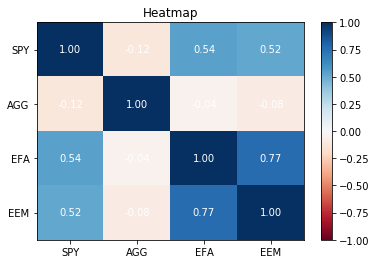

In [147]:
returns.plot_corr_heatmap()

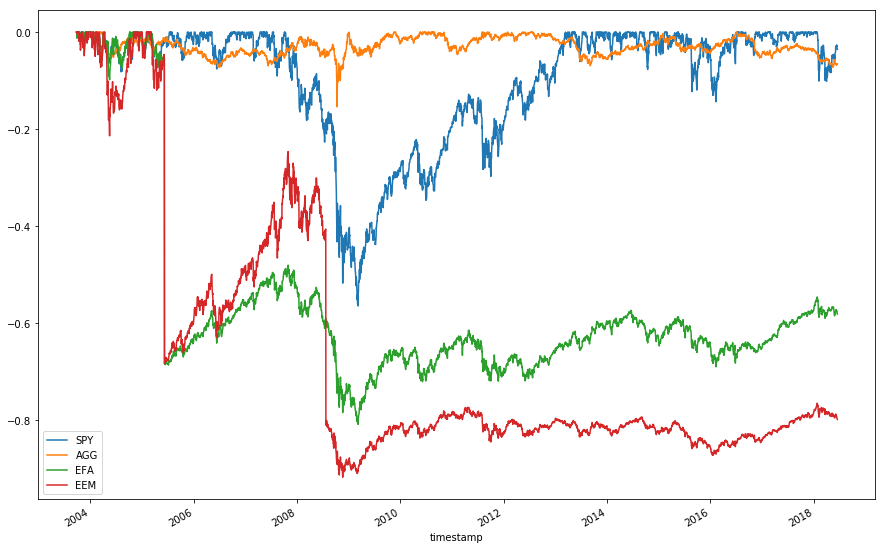

In [148]:
ffn.to_drawdown_series(test).plot(figsize=(15,10))